# Youtube Channel Analysis: Data collected by making an API call

In [1]:
#!pip install wordcloud

In [2]:
# import libraries
import requests
import pandas as pd
import time
import datetime
import isodate
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import matplotlib.ticker as ticker

#NLP
from wordcloud import WordCloud,STOPWORDS

In [3]:
# API parameters
channel_ID='UCoOae5nYA7VqaXzerajD0lg'# Channel Name: Ali abdaal
API_KEY='xxxxxxx'

In [4]:
df_ex=pd.DataFrame(columns=['title','subscriberCount','viewCount','hiddenSubscriberCount','videoCount','Playlist_id'])

url1 = "https://www.googleapis.com/youtube/v3/channels"

params={   
    "part":["snippet","contentDetails","statistics"],# mention what properties we want to look at
    "id":channel_ID,# we have channel ID of youtuber Ali Abdaal
    "maxResults":10000,
    "key":API_KEY}

# making an API call   
#converting it into json format,like attribute value pair
response_play=requests.get(url1,params=params).json()

# retrieving data from the response
title=response_play['items'][0]['snippet']['title']
Playlist_id=response_play['items'][0]['contentDetails']['relatedPlaylists']["uploads"]
viewCount=response_play['items'][0]['statistics']['viewCount']
subscriberCount=response_play['items'][0]['statistics']['subscriberCount']
hiddenSubscriberCount=response_play['items'][0]['statistics']['hiddenSubscriberCount']
videoCount=response_play['items'][0]['statistics']['videoCount']

# create a dictionary 
data_to_add={'title':title,
             'subscriberCount':subscriberCount,
             'viewCount':viewCount,
             'hiddenSubscriberCount':hiddenSubscriberCount,
             'videoCount':videoCount,
             'Playlist_id':Playlist_id}

# convert dictionary to a pandas dataframe
data_to_add=pd.DataFrame.from_dict([data_to_add])

# concatenate it with df
df_ex=pd.concat([df_ex,data_to_add])

df_ex

,title,subscriberCount,viewCount,hiddenSubscriberCount,videoCount,Playlist_id
0,Ali Abdaal,4110000,307648043,False,612,UUoOae5nYA7VqaXzerajD0lg


<b>Inference:</b></br>
    1. Ali abdaal channel has a total of 4.1M subscribers</br>
    2. There are a total of 611 vedios in this channel</br>

## Retrieving statistics and details of of all the vedios of his channel

In [5]:
# create a function to retrieve vedio statistics
def vedio_stat(videoId):
    url3='https://www.googleapis.com/youtube/v3/videos'
    params={   
        "part":["snippet","contentDetails","statistics"],
        "id":videoId,
        "maxResults":50,
        "key":API_KEY}
    #make an API call
    response_ved_det=requests.get(url3,params=params).json()
    # check the kind attribute value from the response is equal to youtube#video
    if response_ved_det["items"][0]['kind']=='youtube#video':
        #get the vedio statistics
        channelTitle=response_ved_det["items"][0]['snippet']['channelTitle']
        categoryId=response_ved_det["items"][0]['snippet']['categoryId']
        description=response_ved_det["items"][0]['snippet']['description']
        
        # theres can be vedios without any tags, use try catch to avaoid the errors
        try:
             tags=response_ved_det["items"][0]['snippet']['tags']
        except:
            tags=None
            
        publishedAt=response_ved_det["items"][0]['snippet']['publishedAt']
        
        duration=response_ved_det["items"][0]['contentDetails']['duration']
        definition=response_ved_det["items"][0]['contentDetails']['definition']
        caption=response_ved_det["items"][0]['contentDetails']['caption']
        
        viewCount=response_ved_det["items"][0]['statistics']['viewCount']
        likeCount=response_ved_det["items"][0]['statistics']['likeCount']
        favoriteCount=response_ved_det["items"][0]['statistics']['favoriteCount']
        commentCount=response_ved_det["items"][0]['statistics']['commentCount']
    #return the values       
    return channelTitle,categoryId,description,publishedAt,duration,viewCount,likeCount,favoriteCount,commentCount,tags,definition,caption     

In [6]:
# create an another function to extract vedio id's & its details from playlistid
def vedio_det(df,Playlist_id):
    # initialize variable nextPageToken as null
    nextPageToken = ""
    # create a while loop to iterate through the all pages until the value in nextPageToken is None
    while nextPageToken is not None:
        # make an api call to retrieve vedio id's from the playlist
        url2='https://www.googleapis.com/youtube/v3/playlistItems'
        params={   
            "part":["snippet","contentDetails"],
            "playlistId":Playlist_id,
            "maxResults":50,
            "key":API_KEY,
            "pageToken":nextPageToken}
        response_ved=requests.get(url2,params=params).json()
        nextPageToken=response_ved.get('nextPageToken')
        # give 1 second to load the complete data
        time.sleep(1)
        
        # iterate though each items in the response
        for item in response_ved['items']:
            # get the details from the response
            videoId=item['contentDetails']['videoId']
            #videoPublishedAt=item['contentDetails']['videoPublishedAt'].split('T')[0]
            title=item['snippet']['title'].replace("&amp;","")
            
            # making call to another function & retrieving the vedio statistics from the function
            channelTitle,categoryId,description,publishedAt,duration,viewCount,likeCount,favoriteCount,commentCount,tags,definition,caption =vedio_stat(videoId)

            # creating an dictionary
            data_to_add={
                         'channelTitle':channelTitle,
                         'videoId':videoId,
                         'description':description,
                         'publishedAt':publishedAt,
                         'duration':duration,
                         'viewCount':viewCount,
                         'likeCount':likeCount,
                         'favoriteCount':favoriteCount,
                         'commentCount':commentCount,
                         'categoryId':categoryId,
                         'title':title,
                         'tags':tags,
                         'definition':definition,
                         'caption':caption}
            # convert it into dataframe
            data_to_add=pd.DataFrame.from_dict([data_to_add])
            # concatenating with df
            df=pd.concat([df,data_to_add])
        
        # get the nextpagetoken value from the response   
        nextPageToken=response_ved.get('nextPageToken')
    
    #return the updated df        
    return df 

In [7]:
# create a function to extract playlist Id of the channel
def playlist_details(df):
    url1 = "https://www.googleapis.com/youtube/v3/channels"

    #create a dictionary with all the parameters
    params={   
        "part":["snippet","contentDetails","statistics"],# properties we want to look at
        "id":channel_ID,# we have this value
        "maxResults":10000,
        "key":API_KEY}

    # make an API call and save the response in json format
    response_play=requests.get(url1,params=params).json()
    
    # retrieve the playlist id from the response
    Playlist_id=response_play['items'][0]['contentDetails']['relatedPlaylists']["uploads"]
    # passing playlistId to the function vedio_det
    df=vedio_det(df,Playlist_id)
    
    # returning the received output to the caller
    return df 

In [8]:
# create an empty dataframe, column order should match with data that returing from the function
df=pd.DataFrame(columns=['channelTitle','videoId','description','publishedAt','duration','viewCount','likeCount','favoriteCount','commentCount','categoryId','title','definition','caption'])

# call the function playlist_details, we have passed the empty array
df=playlist_details(df)

# obtained dataframe 
df

,channelTitle,videoId,description,publishedAt,duration,viewCount,likeCount,favoriteCount,commentCount,categoryId,title,definition,caption,tags
0,Ali Abdaal,Lsq6gN1_FLo,"🎙 If you liked this, check out my weekly podca...",2023-04-11T16:58:09Z,PT52S,42052,4009,0,32,27,Jack's Paradox of Choice 😰,hd,false,"[Ali Abdaal, Ali abdal]"
0,Ali Abdaal,oFRdwK57dYY,"🎙 If you liked this, check out my weekly podca...",2023-04-09T12:00:39Z,PT53S,105892,10804,0,60,27,Leonardo Da Vinci's Biggest Secret 🤫,hd,false,"[Ali Abdaal, Ali abdal]"
0,Ali Abdaal,JMh44cq60UE,Sign up to Morning Brew for free today: https:...,2023-04-08T12:00:21Z,PT11M47S,235736,13513,0,315,27,7 Habits to Be a Millionaire by 30,hd,true,"[Ali Abdaal, Ali abdal, asking millionaires ho..."
0,Ali Abdaal,lpkC5h-5Pmk,"🎙 If you liked this, check out my weekly podca...",2023-04-06T12:00:35Z,PT45S,96655,7321,0,34,27,The Pareto Principle 👩‍🌾,hd,false,"[Ali Abdaal, Ali abdal]"
0,Ali Abdaal,qWMK16uYQbU,Thanks to Trading 212 for sponsoring this vide...,2023-04-05T16:00:39Z,PT15M2S,171282,8406,0,264,27,"How I Made $1,600,000 in 30 Days",hd,false,"[Ali Abdaal, Ali abdal, alex hormozi, 100m off..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,Ali Abdaal,7APfFjfnNBc,"First cover of 2017! We both love this song, s...",2017-01-04T23:13:51Z,PT2M35S,80921,2069,0,114,27,Payphone (Maroon 5) - Katherine Macfarland & A...,hd,false,"[payphone, maroon 5, acoustic cover, cover]"
0,Ali Abdaal,gBpBLTSCb4s,The 6med UKCAT Crash Course is the most effect...,2016-05-09T18:45:18Z,PT2M11S,14489,103,0,4,27,6med UKCAT Crash Course - In a Nutshell,hd,false,"[6med, medical school, ukcat, medicine]"
0,Ali Abdaal,Va0tSdPADpA,The 6med BMAT Crash Course is the most effecti...,2016-04-27T09:04:49Z,PT2M18S,36191,268,0,9,27,6med BMAT Crash Course - In a Nutshell,hd,false,"[BMAT, 6med, medicine, medical students]"
0,Ali Abdaal,XJHM0fEH3ss,Our first 'proper' video! One of our all-time ...,2016-04-05T09:05:29Z,PT2M29S,52139,647,0,30,10,Rolling in the Deep (Adele) - Duranka Perera &...,hd,false,"[rolling in the deep, adele, cover, acoustic]"


## Data Inspection

In [9]:
#shape of the dataframe
df.shape

(609, 14)

Previously we have checked the total vedio count and it was 611. but its showing 608 in our dataframe. 
This may be due to  missing vedios are private or deleted or may not visible in the API response due to restrictions on the video or the user's region.

In [10]:
# check the data type of df
df.dtypes

channelTitle     object
videoId          object
description      object
publishedAt      object
duration         object
viewCount        object
likeCount        object
favoriteCount    object
commentCount     object
categoryId       object
title            object
definition       object
caption          object
tags             object
dtype: object

all features are of object type. we need to convert the viewcount,likecount,favoriteCount,commentCount to integer.



In [11]:
# info of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 609 entries, 0 to 0
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   channelTitle   609 non-null    object
 1   videoId        609 non-null    object
 2   description    609 non-null    object
 3   publishedAt    609 non-null    object
 4   duration       609 non-null    object
 5   viewCount      609 non-null    object
 6   likeCount      609 non-null    object
 7   favoriteCount  609 non-null    object
 8   commentCount   609 non-null    object
 9   categoryId     609 non-null    object
 10  title          609 non-null    object
 11  definition     609 non-null    object
 12  caption        609 non-null    object
 13  tags           592 non-null    object
dtypes: object(14)
memory usage: 71.4+ KB


there is no null value present in the dataframe

In [12]:
# statistic summary of df
df.describe().T

,count,unique,top,freq
channelTitle,609,1,Ali Abdaal,609
videoId,609,609,Lsq6gN1_FLo,1
description,609,555,"🎙 If you liked this, check out my weekly podca...",23
publishedAt,609,609,2023-04-11T16:58:09Z,1
duration,609,461,PT1M,18
viewCount,609,609,42052,1
likeCount,609,601,7029,2
favoriteCount,609,1,0,609
commentCount,609,476,29,5
categoryId,609,7,27,475


since all features are of object type. it will only show count, unique and frequency details

## Data Preprocessing

In [13]:
# check for null values
df.isna().sum()

channelTitle      0
videoId           0
description       0
publishedAt       0
duration          0
viewCount         0
likeCount         0
favoriteCount     0
commentCount      0
categoryId        0
title             0
definition        0
caption           0
tags             17
dtype: int64

there are null values present in tags column

In [14]:
# convert count columns to integer type

cols=["viewCount","likeCount","favoriteCount","commentCount"]

for col in cols:
    df[col]=df[col].apply(lambda x: int(x))

In [15]:
# convert publish date into pandas date format

df['publishedAt']=pd.to_datetime(df['publishedAt'])

In [16]:
# create new feature for dayname
df["PublishDay"]=df['publishedAt'].dt.day_name()

In [17]:
# convert the duration to numeric
df["duration"]=df["duration"].apply(lambda x: isodate.parse_duration(x).total_seconds())

In [18]:
# add new column for number of tags
# if-else used to handle None values
df["Tags_count"]=df["tags"].apply(lambda x:0 if x is None else len(x))

In [19]:
# create new feature for year
df["Publishyear"]=df['publishedAt'].dt.year

## Exploratory Data Analysis

### Top 10 Best Performing Videos

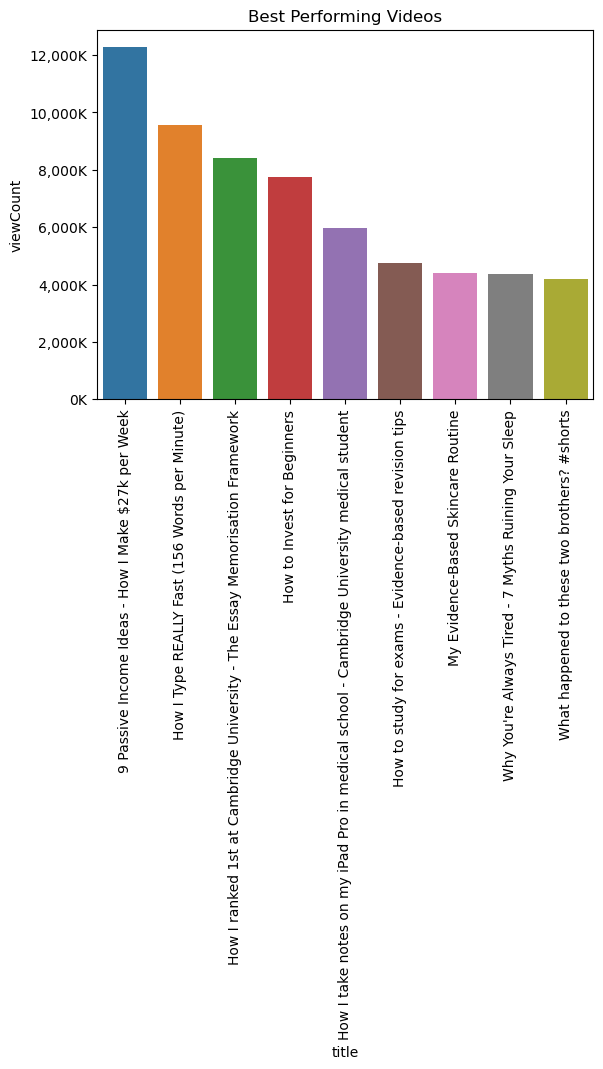

In [20]:
# Analysis of view per vedio

ax=sns.barplot(x="title",y="viewCount",data=df.sort_values(by="viewCount",ascending=False)[0:9])
plt.xticks(rotation=90)
#set the y-axis ticks to k format using the FuncFormatter from matplotlib.ticker
#The format_ticks function takes the tick value and position as input, checks if the value is greater than or equal to 1000, and formats it in k format accordingly

ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}K'.format(x/1000)))
plt.title("Best Performing Videos")
plt.show()

Inference: </br>
    1. High performing vedio is '9 Passive Income Ideas-How I MAke $27 per Week'

### Top 10 Worst Performing Videos

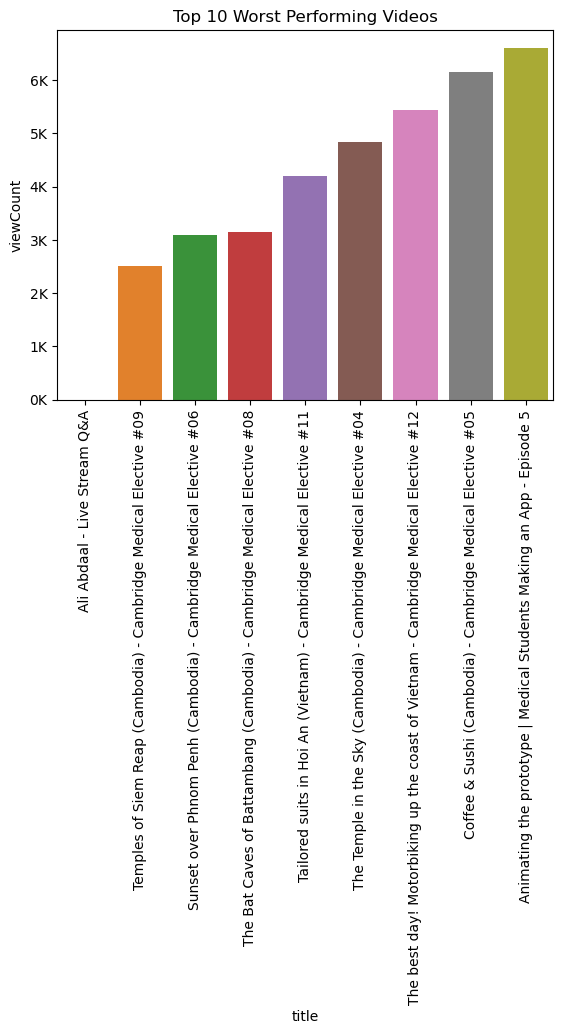

In [21]:
# analysis of worst performing videos
# create the barplot
ax=sns.barplot(x="title",y="viewCount",data=df.sort_values("viewCount")[0:9])
plt.xticks(rotation=90)
#set the y-axis ticks to k format
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}K'.format(x/1000)))
plt.title("Top 10 Worst Performing Videos")
plt.show()

Inference:</br>
    These are the videos published at the start time

### Like & Comments vs View

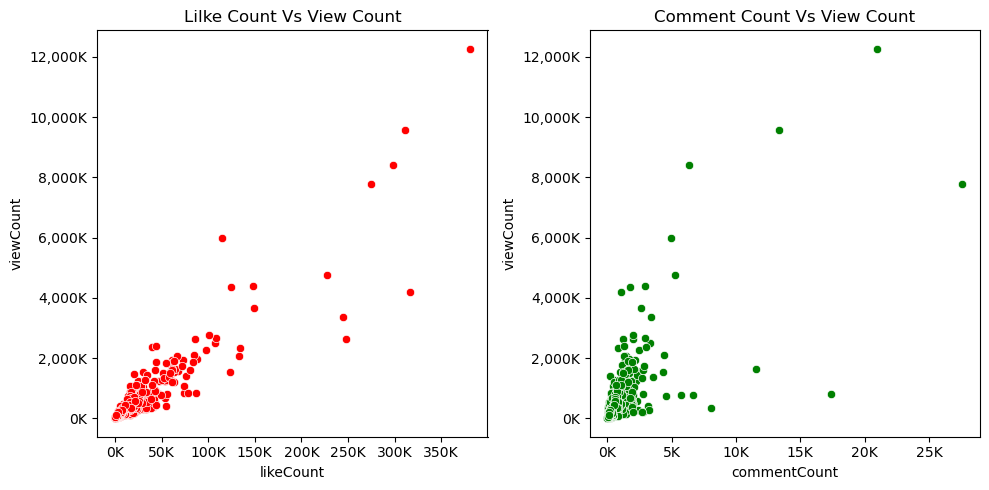

In [22]:
# use scatter plot to see the relation
# devide the plot area into 2 
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
# create scatter plot 
ax=sns.scatterplot(x="likeCount",y="viewCount", data=df,color='red')
#set the x& y-axis ticks to k format
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}K'.format(x/1000)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}K'.format(x/1000)))
plt.title("Lilke Count Vs View Count")

plt.subplot(1,2,2)
# create scatter plot 
ax=sns.scatterplot(x="commentCount",y="viewCount", data=df,color='green')
#set the x& y-axis ticks to k format
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}K'.format(x/1000)))
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x,pos:'{:,.0f}K'.format(x/1000)))
plt.title("Comment Count Vs View Count")
plt.tight_layout()

Inference:</br>
    1. We can see a linear relation between likeCount and View Count & also between comment count & View count </br>
    2. There are some outliers in the like count & Comment Count</br>

### Publish day vs Video Count

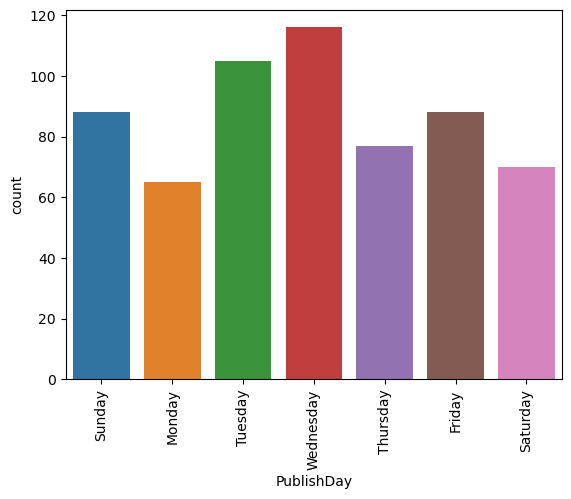

In [23]:
# Sort the DataFrame by the publish day
# define the order we want
order=['Sunday', 'Monday', 'Tuesday','Wednesday','Thursday', 'Friday', 'Saturday']

# Create the bar plot, set the order
ax = sns.countplot(x="PublishDay", data=df, order=order)

# Set the x-axis tick labels
ax.set_xticklabels(order,rotation=90)
plt.show()

Inference:</br>
    Most of the videos are published on Wednesday and Tuesday

### Distribution of Video Duration 

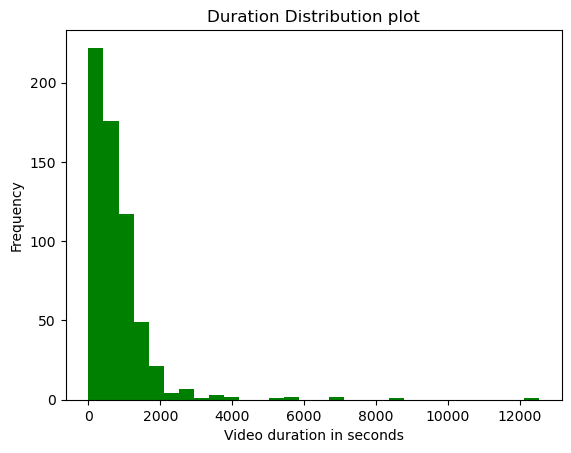

In [24]:
# create a histogram for duration

plt.hist(df["duration"],bins=30,color='green')
plt.title("Duration Distribution plot")
plt.xlabel("Video duration in seconds")
plt.ylabel("Frequency")
plt.show()

Inference:<br>
1.Most of the videos are of 10-15 minutes duration</br>
2.There are some outliers, highest duration is around 3 hrs(~12000seconds)


### View Distribution per Video

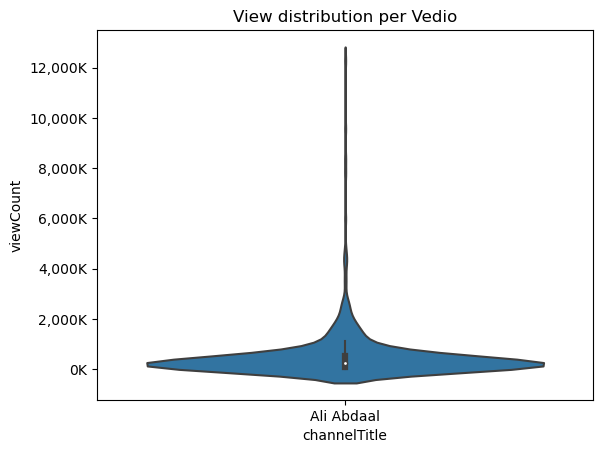

In [25]:
ax=sns.violinplot(x=df["channelTitle"],y=df['viewCount'])
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos:'{:,.0f}K'.format(x/1000)))
plt.title("View distribution per Vedio")
plt.show()

Inference:</br>
1.Average view count per video is around 500K across the channel</br>
2. There are some outliers in the viewcount</br>

### Number of Videos vs Year

Text(0.5, 1.0, 'Number of Videos vs Year')

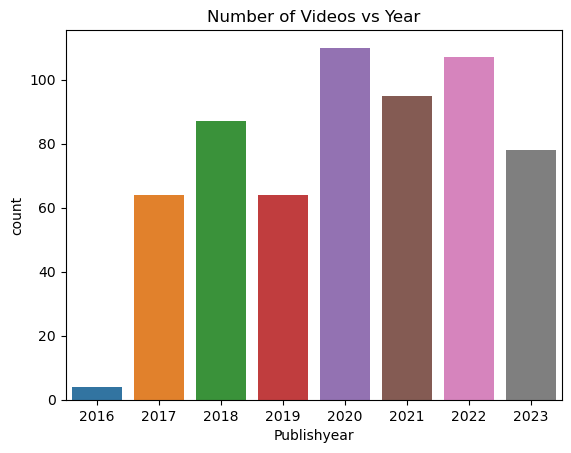

In [26]:
# Videos vs year
ax=sns.countplot(df["Publishyear"].sort_values(ascending=False))
ax.set_title("Number of Videos vs Year")

Inference:</br>
    1. The first video was uploaded in 2016</br>
    2. The highest number of videos were published in 2020 & 2022</br>

### Tag count vs View Count

<AxesSubplot:xlabel='Tags_count', ylabel='viewCount'>

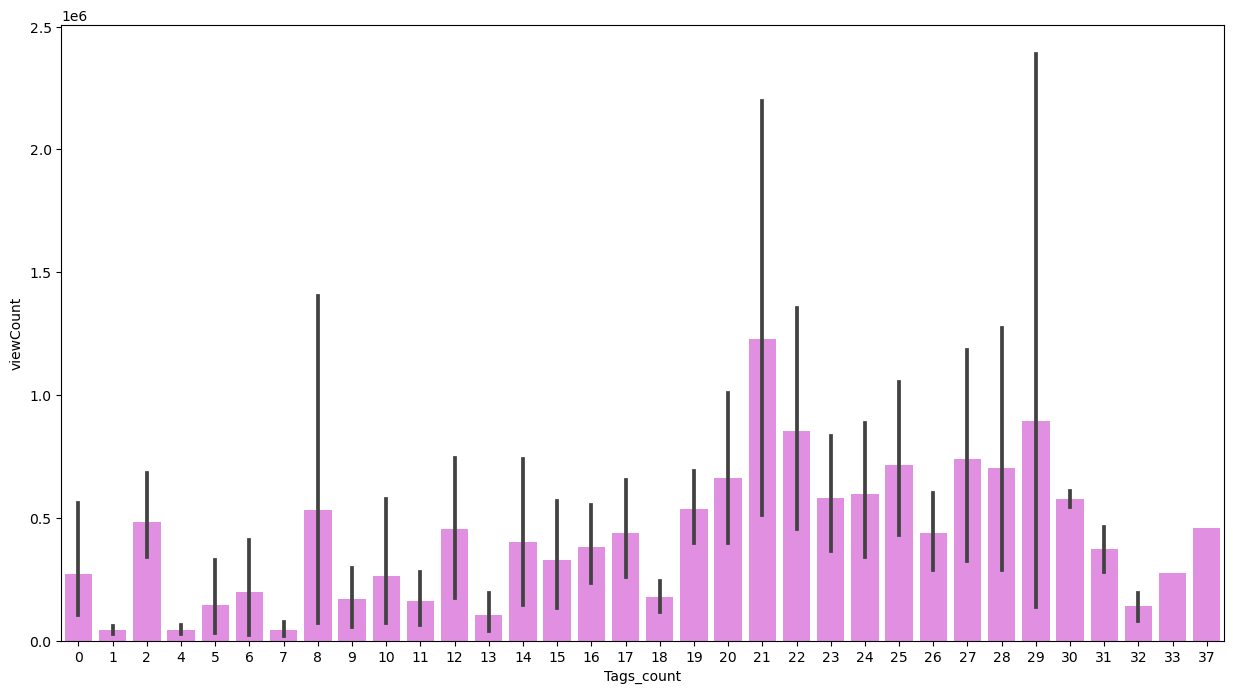

In [27]:
# create a scatter plot between tag count and view count

plt.figure(figsize=(15,8))
sns.barplot(x="Tags_count",y="viewCount",data=df,color='violet')

Tags count has an good impact on number of views

### Most Frequent words in Video Titles-using NLP WordCloud function

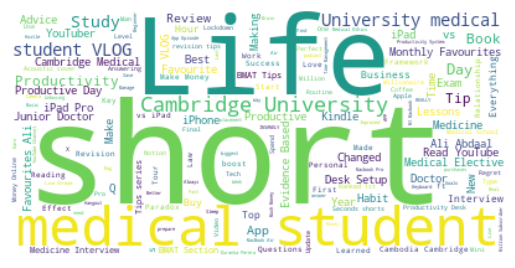

In [28]:
# Preprocess the title data
text = " ".join(video_title for video_title in df['title'])
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(text)

# Visualize the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Insight:  most repeating word in his video title's are medical, short,Life,student,Cambridge University

WordCloud Function:</br>
    1. First we will combine the titles into a single text</br>
    2. The stopwords parameter in the WordCloud function contains a set of common English words that we want to ignore in the word cloud</br>
    3. Generate the wordCloud over the text</br>
    4. The imshow function is used to display the word cloud image</br>
    5. The interpolation is used to smooth the heatmap image to make it look more visually appealing</br>